Imports

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from io import BytesIO
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
tf.keras.utils.set_random_seed(
    seed = 42
)

In [ ]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
coco_data_dir = '/content/gdrive/My Drive/Colab Notebooks/DATA/Bilder' #Folder with provided Images
add_data_file = '/content/gdrive/My Drive/Colab Notebooks/DATA/DATATHON_add.xlsx' #File with Structured Data
coco_json_file = '/content/gdrive/My Drive/Colab Notebooks/segmentation.json' #Annotated File for Images

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Loading/ Preprocessing Annotated Images in Coco Format

In [ ]:
# Load the annotations
with open(coco_json_file) as f:
    annotations = json.load(f)

# Load structured data
structured_data = pd.read_excel(add_data_file)

In [ ]:
# Function to load and preprocess an image
def preprocess_image(img_path, bbox=None):
    img = Image.open(img_path).convert('RGB')
    if bbox is not None:
        img = img.crop(bbox)  # Crop the image based on the bounding box
    img = img.resize((224, 224))  # Resize the cropped image
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255.0  # Normalize to [0,1]
    return img

In [ ]:
# Load the pre-trained model
base_model = EfficientNetB0(include_top=False, weights='imagenet')

In [ ]:
# Preprocess all images
image_features = []
for img in annotations['images']:
    img_id = img['id']
    img_file = img['file_name'].split("/")[-1]
    img_path = coco_data_dir + "/" + img_file
    img_annotations = [anno for anno in annotations['annotations'] if anno['image_id'] == img_id]
    
    if img_annotations:
        bbox = img_annotations[0]['bbox']  # Get the bounding box
        bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]  # Convert to [left, upper, right, lower]
    else:
        bbox = None
    
    img = preprocess_image(img_path, bbox)
    print(f'Preprocessed image shape: {img.shape}')  # Print the shape of the preprocessed image

    if bbox is not None:
        print(f'Bounding box: {bbox}')  # Print the bounding box coordinates

    try:
        features = base_model.predict(img)
        image_features.append(features)
    except Exception as e:
        print(f'Error processing image {img_file}: {e}')  # Print any error messages

X_images = np.array(image_features)


Preprocessed image shape: (1, 224, 224, 3)
Bounding box: [0.10248774509803922, 0.5850206611570248, 0.7675857843137255, 0.9916322314049587]
1/1 [==============================] - 4s 4s/step
Preprocessed image shape: (1, 224, 224, 3)
Bounding box: [0.1850284090909091, 0.40467257844474763, 0.6777556818181818, 0.7689290586630286]
1/1 [==============================] - 0s 264ms/step
Preprocessed image shape: (1, 224, 224, 3)
Bounding box: [0.376103505629478, 0.42513642564802184, 0.7415078045035824, 0.576568894952251]
1/1 [==============================] - 0s 398ms/step
Preprocessed image shape: (1, 224, 224, 3)
Bounding box: [0.05622657922912205, 0.003744650499286733, 0.8442351445396146, 0.8725035663338089]
1/1 [==============================] - 0s 127ms/step
Preprocessed image shape: (1, 224, 224, 3)
Bounding box: [0.19891599716446126, 0.07507132667617689, 0.9314301748582231, 0.9937589158345221]
1/1 [==============================] - 0s 88ms/step
Preprocessed image shape: (1, 224, 224, 3)


# Preprocess Structured Data

In [ ]:
def map_damage(damage):
    if 0 <= damage <= 7000:
        return 'small'
    elif 7001 <= damage <= 50000:
        return 'medium'
    else:
        return 'high'

def preprocess_structured_data(structured_data):
    # Convert 'Baujahr' to age of the building in years
    structured_data['Baujahr'] = 2023 - structured_data['Baujahr']

    # Normalize 'Baujahr' to be between 0 and 1
    structured_data['Baujahr'] = structured_data['Baujahr'] / structured_data['Baujahr'].max()

    # Normalize 'Postleitzahl' to be between 0 and 1
    structured_data['Postleitzahl'] = structured_data['Postleitzahl'] / structured_data['Postleitzahl'].max()

    # Normalize 'Etage' to be between 0 and 1
    structured_data['Etage ganze Zahl'] = structured_data['Etage ganze Zahl'] / structured_data['Etage ganze Zahl'].max()

    # Normalize 'Dauer des Schadens in Tagen' to be between 0 and 1
    structured_data['Dauer des Schadens in Tagen'] = structured_data['Dauer des Schadens in Tagen'] / structured_data['Dauer des Schadens in Tagen'].max()

    # One-hot encode the 'Material' column
    structured_data = pd.get_dummies(structured_data, columns=['Material'])

    # Return the preprocessed structured data
    return structured_data


# Apply the function to the 'Schadenhöhe' column
structured_data['Schadenhöhe'] = structured_data['Schadenhöhe'].apply(map_damage)

#get One Hot Encoding for Material Column
processed_structured_data = preprocess_structured_data(structured_data)


In [ ]:
X_images = np.array(image_features)
X_structured = processed_structured_data.drop(columns=['ID', 'Schadenhöhe']).to_numpy()
y = to_categorical(processed_structured_data['Schadenhöhe'].map({'small': 0, 'medium': 1, 'high': 2}))

# Split the data into training and validation sets
X_structured_train, X_structured_val, X_images_train, X_images_val, y_train, y_val = train_test_split(
    X_structured, X_images, y, test_size=0.2, random_state=42
)

X_structured_train = X_structured_train.astype('float32')
X_structured_val = X_structured_val.astype('float32')


In [ ]:
X_structured_train

array([[0.25      , 0.8181818 , 0.06666667, 0.6065674 , 1.        ,
        0.        , 0.        ],
       [0.8333333 , 0.45454547, 0.4       , 0.9269761 , 1.        ,
        0.        , 0.        ],
       [0.        , 0.16883117, 0.26666668, 0.72710824, 0.        ,
        0.        , 1.        ],
       [0.        , 0.25974026, 0.46666667, 0.6737254 , 1.        ,
        0.        , 0.        ],
       [0.41666666, 0.07792208, 0.26666668, 0.35000253, 1.        ,
        0.        , 0.        ],
       [0.16666667, 0.16883117, 0.33333334, 0.04248462, 1.        ,
        0.        , 0.        ],
       [0.33333334, 0.18181819, 0.46666667, 0.7341839 , 1.        ,
        0.        , 0.        ],
       [0.        , 0.6948052 , 0.33333334, 0.00652671, 1.        ,
        0.        , 0.        ],
       [0.16666667, 0.5064935 , 0.33333334, 0.739694  , 1.        ,
        0.        , 0.        ],
       [1.        , 0.16233766, 0.53333336, 0.4989478 , 1.        ,
        0.        , 0. 

# Define / Finetune ML Model

In [ ]:
# Define new model on top
inputs_structured = layers.Input(shape=(X_structured.shape[1],))
inputs_images = layers.Input(shape=(1, 7, 7, 1280))  # Adjust input shape to match data


x_structured = layers.Dense(64, activation='relu')(inputs_structured)
x_structured = layers.BatchNormalization()(x_structured)
x_structured = layers.Dropout(0.5)(x_structured)


x_images = layers.Reshape((7, 7, 1280))(inputs_images)  # Reshape to remove the extra dimension
x_images = layers.GlobalAveragePooling2D()(x_images)
x_images = layers.Dense(64, activation='relu')(x_images)
x_images = layers.BatchNormalization()(x_images)
x_images = layers.Dropout(0.5)(x_images)

x = layers.Concatenate()([x_structured, x_images])
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(3, activation='softmax')(x)

model = Model([inputs_structured, inputs_images], outputs)

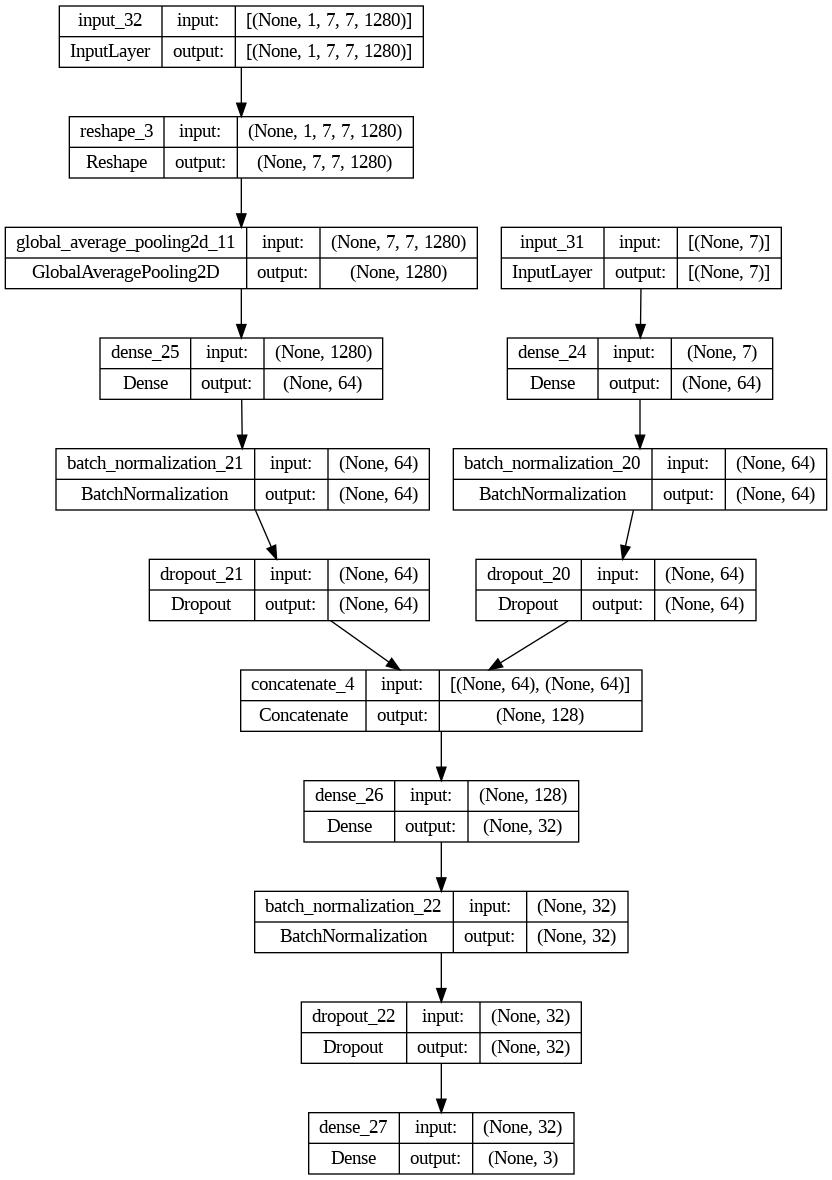

In [ ]:
tf.keras.utils.plot_model (model, to_file = "model.jpg", show_shapes = True, show_layer_names = True)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# train the model with your specific data
model.fit([X_structured_train, X_images_train], y_train,
          validation_data=([X_structured_val, X_images_val], y_val),
          epochs=33, batch_size=32)

Epoch 1/33
3/3 [==============================] - 0s 44ms/step - loss: 0.5022 - accuracy: 0.8250 - val_loss: 1.1598 - val_accuracy: 0.8500
Epoch 2/33
3/3 [==============================] - 0s 31ms/step - loss: 0.5235 - accuracy: 0.8000 - val_loss: 1.1866 - val_accuracy: 0.8500
Epoch 3/33
3/3 [==============================] - 0s 36ms/step - loss: 0.6001 - accuracy: 0.7375 - val_loss: 1.2178 - val_accuracy: 0.8500
Epoch 4/33
3/3 [==============================] - 0s 41ms/step - loss: 0.4917 - accuracy: 0.8375 - val_loss: 1.2610 - val_accuracy: 0.8500
Epoch 5/33
3/3 [==============================] - 0s 32ms/step - loss: 0.5917 - accuracy: 0.7125 - val_loss: 1.2872 - val_accuracy: 0.8500
Epoch 6/33
3/3 [==============================] - 0s 27ms/step - loss: 0.5513 - accuracy: 0.7875 - val_loss: 1.2939 - val_accuracy: 0.8500
Epoch 7/33
3/3 [==============================] - 0s 26ms/step - loss: 0.5339 - accuracy: 0.8125 - val_loss: 1.3075 - val_accuracy: 0.8500
Epoch 8/33
3/3 [===========

In [ ]:
# Choose an example from the validation set
example_index = 3
example_images = X_images_val[example_index]
example_structured = X_structured_val[example_index]

# Note: the inputs to the model's predict method need to have an extra dimension
# because the method is expecting a batch of examples. We can add the extra dimension
# using np.expand_dims.
example_images = np.expand_dims(example_images, axis=0)
example_structured = np.expand_dims(example_structured, axis=0)

# Predict the class probabilities for the example
class_probabilities = model.predict([example_structured, example_images])

# Decode the class probabilities to obtain the class label
class_label = np.argmax(class_probabilities, axis=1)
class_label_mapping = {0: "small", 1: "medium", 2: "high"}
predicted_class = class_label_mapping[class_label[0]]

print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 25ms/step
Predicted class: medium


Implement Test Function for new Picture

In [ ]:
def predict_damage_classification(image_path, new_structured_data):

    # preprocess image
    # Use None if the new image doesn't have a bbox / not annotated
    new_image = preprocess_image(image_path, None) 

    image_processed = np.array([base_model.predict(new_image)])

    # Convert the new structured data into an array
    new_structured_array = np.array(list(new_structured_data.values())).reshape(1, -1)    

    # Predict the class probabilities for the new example
    class_probabilities = model.predict([new_structured_array, image_processed])
    class_label = np.argmax(class_probabilities, axis=1)
    class_label_mapping = {0: "small", 1: "medium", 2: "high"}
    predicted_class = class_label_mapping[class_label[0]]
    
    return predicted_class

In [ ]:
# Load a new image
new_image_path = "ID_12.jpg"

# Create a new structured data example
# Replace these values with the actual data for the new example
new_structured_data = {
    "Etage ganze Zahl": 4,
    "Baujahr": 1955,
    "Dauer des Schadens in Tagen": 100,
    "Postleitzahl": 76532,
    "Material_Beton": 1,
    "Material_Stein": 0,
    "Material_Holz": 0
}


predicted_class = predict_damage_classification(new_image_path,new_structured_data)
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 38ms/step
Predicted class: small
